# Training model example

# Setup

**Import libraries**

In [51]:
# project main library
import src.emnist_utils as utils
from src.data_container import DataContainer

# Data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data preprocessing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# ML models suited for classification tasks
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# ML pipeline
from sklearn.pipeline import Pipeline

# Libraries that support model selection and parameter tuning
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# metrics that are used to evaluate performance of ML models
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# lib helping to save and load models
import joblib

# python libraries
from pathlib import Path

**Set random seed**

In [2]:
# set random seed to specific value so that all random results are the same across multiple runs
np.random.seed(42)

**Create directory figures to store pyplot figures**

In [54]:
# Programmatically create directory to store figures
FIGURES_PATH = Path().absolute().parent / "figures"
if not FIGURES_PATH.exists():
    FIGURES_PATH.mkdir(parents=True, exist_ok=True)

# use this function to save figures
# utils.save_fig("figure_name")
# you will use this function later

In [55]:
# check figures path
print(FIGURES_PATH)

/home/tringuyen/Docus/homl3/ch03/emnist_clf/figures


# Load data

In [4]:
# DataContainer is a wrapper object that contains all needed data
dc = DataContainer()

# load data to DataContainer
dc.load_emnist()

In [5]:
# check if data is loaded properly
print("X_train shape: ", dc.X_train.shape)
print("y_train shape: ", dc.y_train.shape)
print("X_test shape: ", dc.X_test.shape)
print("y_test shape: ", dc.y_test.shape)

X_train shape:  (112800, 784)
y_train shape:  (112800,)
X_test shape:  (18800, 784)
y_test shape:  (18800,)


<Axes: >

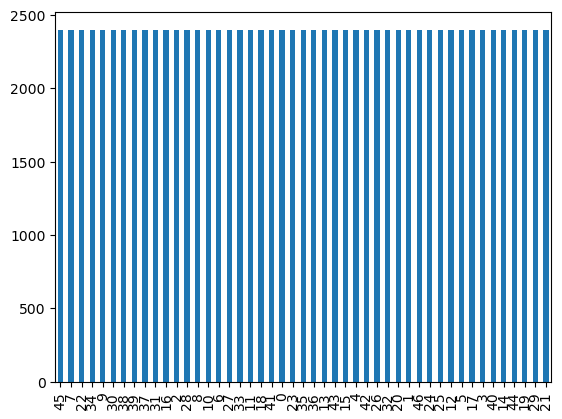

In [6]:
# draw distribution of characters in the dataset
pd.Series(dc.y_train).value_counts().plot(kind='bar')

We see in figure above that the dataset is balanced, with 2400 train samples per class

Number of classes: 47
Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'd' 'e' 'f' 'g' 'h' 'n' 'q' 'r' 't']


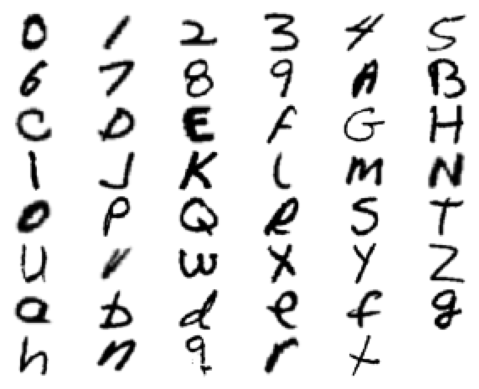

In [7]:
# plot all character classes in the dataset
char_classes = dc.map_label_to_char(dc.mapping)
print("Number of classes:", len(char_classes))
print("Classes:", char_classes)
dc.plot_all_chars()

# Data Preprocessing

**Data normalization**

In [8]:
scaler = MinMaxScaler()     # create MinMaxScaler object
scaler.fit_transform(dc.X_train[0:1000]) # fit and transform first 1000 samples

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Other data preprocessing methods**

In [9]:
# Write some code here if additional data preprocessing is needed

# Roughly train some models

Roughly test some classifier model

## Random Forest Classifier model

**Create model**

In [10]:
# create model
rf_clf = RandomForestClassifier() # use default parameters

**Train model**

In [11]:
# try to train and test model with first 10000 samples
rf_clf.fit(dc.X_train[0:10000], dc.y_train[0:10000])

RandomForestClassifier()

**Use model to predict images**

In [24]:
# test with first 2000 samples in test set
predicts = rf_clf.predict(dc.X_test[0:2000])

In [25]:
# calculate accuracy
accuracy = accuracy_score(dc.y_test[0:2000], predicts)

In [26]:
print("Accuracy: ", accuracy)

Accuracy:  0.726


# plot confusion matrix
fig, ax = plt.subplots(figsize=(24, 24)) # set figure size
ConfusionMatrixDisplay.from_predictions(dc.y_test[0:2000], predicts, normalize='true', values_format=".0%", display_labels=dc.char_labels, ax=ax)
utils.save_fig("rf_clf_confusion_matrix")
plt.show()

## KNN Classifier model

In [28]:
# Note that KNN maybe too slow to train/predict with full dataset

In [29]:
# Add code here to train and test KNN model

# Fine-tune model (hyperparameters tweaking)

Use Grid Search or Randomized Search to find the best hyperparameters for the model

## Random Forest Classifier model

**Create pipeline**

In [36]:
# First layer: data preprocessing
scaler = MinMaxScaler()

# Second layer: model
rf_clf = RandomForestClassifier()

# Put two layers together in a pipeline
rf_pipe = Pipeline([
    ('scaler', scaler),
    ('rf', rf_clf)
])

**Using Grid Search**

In [40]:
# create param grid
# Test with 3 different n_estimators, 2 different max_depth
# Testing params set: 4 * 3 = 12
# List prams set: (200, 15), (200, 20), (220, 15), (220, 20), (240, 15), (240, 20)

param_grid = {
    'rf__n_estimators': [200, 220, 240],
    'rf__max_depth': [15, 20]
}

grid_search = GridSearchCV(rf_pipe, param_grid=param_grid,
                           cv=3, scoring='accuracy', return_train_score=True)

In [41]:
# fit params set
# Search with first 4700 samples
grid_search.fit(dc.X_train[0:2350], dc.y_train[0:2350])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [15, 20],
                         'rf__n_estimators': [200, 220, 240]},
             return_train_score=True, scoring='accuracy')

In [45]:
# get result as a dataframs
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_rf__n_estimators", "param_rf__max_depth", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score",
                 "split0_train_score", "split1_train_score", "split2_train_score", "mean_train_score"]]

# vector contain column names used to rename DataFrame columns
score_cols = ["test0_score", "test1_score", "test2_test_score", "mean_test_score",
              "train0_score", "train1_score", "train2_score", "mean_train_score"]

# rename columns
cv_res.columns = ["n_estimators", "max_depth"] + score_cols

In [47]:
# print table result
cv_res

,n_estimators,max_depth,test0_score,test1_score,test2_test_score,mean_test_score,train0_score,train1_score,train2_score,mean_train_score
4,220,20,0.626276,0.595147,0.609195,0.610206,1.0,1.0,1.0,1.0
0,200,15,0.616071,0.591315,0.618135,0.608507,1.0,1.0,1.0,1.0
5,240,20,0.604592,0.588761,0.618135,0.603829,1.0,1.0,1.0,1.0
1,220,15,0.607143,0.592593,0.604087,0.601274,1.0,1.0,1.0,1.0
2,240,15,0.613520,0.587484,0.597701,0.599569,1.0,1.0,1.0,1.0
3,200,20,0.595663,0.587484,0.606641,0.596596,1.0,1.0,1.0,1.0


In table above, we can see that the best params set is (220, 20) with mean test score of 0.61 (61% accuracy)

It is also interesting to see that the model is overfitting with training score of 1.00 (100% accuracy)

Note that we use only first 2350 samples to train the model, if we use all 112800 samples, test score would be higher

**Using Randomized Search**

In [ ]:
# some code here

**Using other methods to fine-tune model**

In [48]:
# some code here

# Save model

Save the model that you are most satisfied with

In [49]:
# Get best model searched by GridSearchCV
best_model = grid_search.best_estimator_

In [56]:
# easily save model with joblib
MODELS_PATH = Path().absolute().parent / "models"
joblib.dump(best_model, MODELS_PATH / "rf_clf.pkl")

['/home/tringuyen/Docus/homl3/ch03/emnist_clf/models/rf_clf.pkl']

# Deploying ML model

Some ways to deploy ML model:
- Web app
- Mobile app
- Desktop app
- Embedded device
- Cloud service
- etc

For example, you can create a RESTFull web service that operates as follows:
- Client sends a request to the server with an image of characters
- Server process the image to make it an 28x28 grayscale image
- The processed will be sent to the model to predict the character
- The server will return the predicted character to the client